# 1. 시계열 데이터 준비
- 컬럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가, 최고가, 최저가, 종가, 수정종가, 거래량이 저장되어 있음.
- 종가만 사용.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



In [2]:
# 데이터 로드 및 Time Series 생성
dataset_filepath = r'C:\Users\user\Desktop\AIFFEL\Day31/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# 2. 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 


Series([], Name: Close, dtype: float64)

In [4]:
ts_log = np.log(ts)

# 3. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

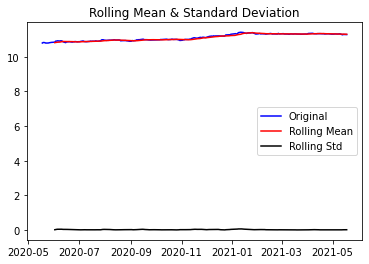

In [5]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window = 12):
    
    # 이동평균 시계열
    rolmean = timeseries.rolling(window = window).mean()
    
    # 이동표준편차 시계열
    rolstd = timeseries.rolling(window = window).std()
    
    # 원본, 이동평균, 이동표준편차를 시각화.
    orig = plt.plot(timeseries, color = 'blue', label ='Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

plot_rolling_statistics(ts_log, window=12)




In [6]:
# 정량적 Augmented Dicky-Fuller Test
def augmented_dickey_fuller_test(timeseries):
    
    # statsmodels 패키지에서 제공하는 adfuller 메서드 호출
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    # adfuller method return result
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


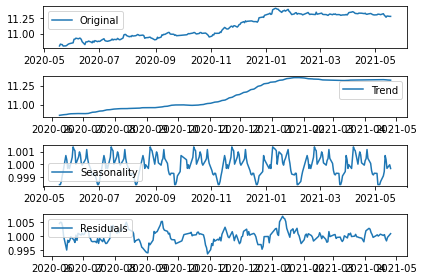

In [7]:
#시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# 4. 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

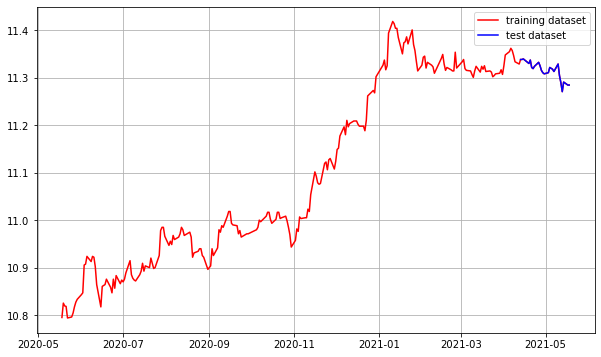

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p, q 구하기
- 차분 안정성 확인 -> d 구하기

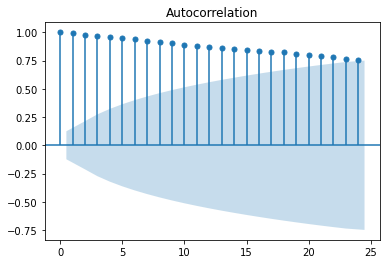

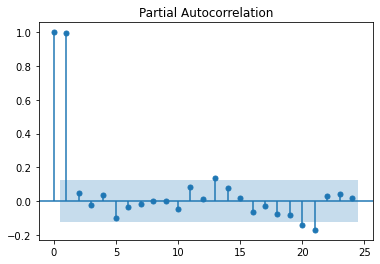

In [10]:
# ACF, PACF 그리기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


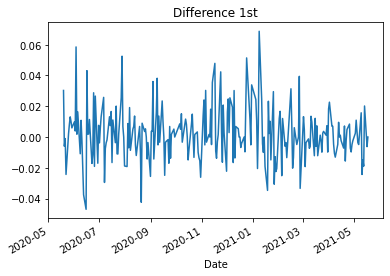

In [11]:
# 차분 안정성 확인

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)



Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


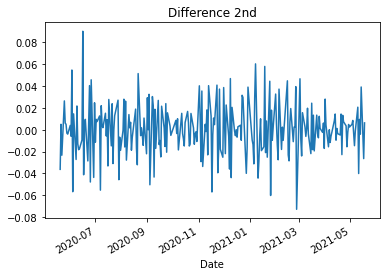

In [12]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정 (MAPE)

In [13]:
# ARIMA Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        03:17:43   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


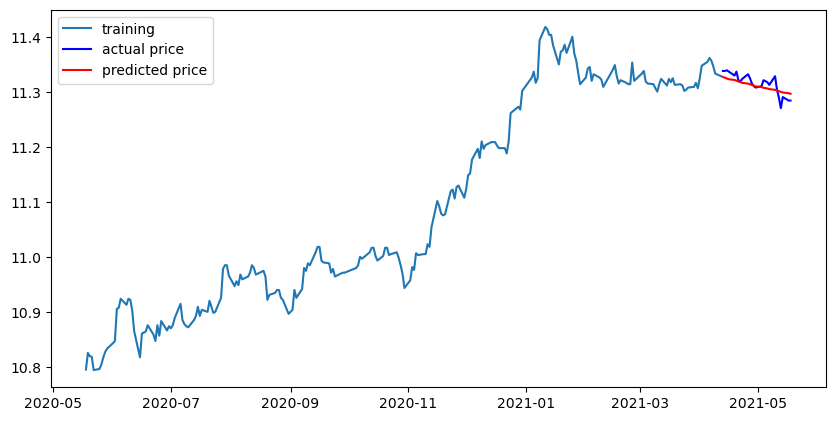

In [14]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [15]:
# 최종 결과 및 MAPE 측정
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014238836
MAE:  843.7579531505163
RMSE:  1024.1941229200077
MAPE: 1.03%


# 7. 다른 주식 종목 예측해 보기

# Rubric
- 1. 시계열의 안정성이 충분히 확인되었는가? -> 플로팅과 adfuller moethod가 적절히 사용되었음.
- 2. ARIMA 모델 모수 선택 근거를 체계적으로 제시하였는가? -> p, q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
- 3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가? -> 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨.

## (1) 데이터 로드

In [16]:
# Time Series 생성
other1_filepath = r'C:/Users/user/Google 드라이브/AIFFEL/Day31/005380.csv'
other1_df = pd.read_csv(other1_filepath, index_col='date', parse_dates=True)

other1_ts = other1_df['close']

other1_ts.head()


date
2016-01-04    144000.0
2016-01-05    143500.0
2016-01-06    140000.0
2016-01-07    137500.0
2016-01-08    136500.0
Name: close, dtype: float64

In [17]:
# Time Series 생성
other2_filepath = r'C:/Users/user/Google 드라이브/AIFFEL/Day31/015760.csv'
other2_df = pd.read_csv(other2_filepath, index_col='date', parse_dates=True)

other2_ts = other2_df['close']

other2_ts.head()


date
2016-01-04    50000.0
2016-01-05    50700.0
2016-01-06    50800.0
2016-01-07    50300.0
2016-01-08    49900.0
Name: close, dtype: float64

In [18]:
other3_filepath = r'C:/Users/user/Google 드라이브/AIFFEL/Day31/051910.csv'
other3_df = pd.read_csv(other3_filepath, index_col='date', parse_dates=True)

other3_ts = other3_df['close']

other3_ts.head()

date
2016-01-04    341500.0
2016-01-05    339500.0
2016-01-06    338000.0
2016-01-07    323000.0
2016-01-08    330000.0
Name: close, dtype: float64

## (2) 전처리 수행

In [19]:
# 결측치 처리
other1_ts = other1_ts.interpolate(method='time')
other2_ts = other2_ts.interpolate(method='time')
other3_ts = other3_ts.interpolate(method='time')




In [20]:
print('{}의 결측치: {}'.format(other1_ts, other1_ts[other1_ts.isna()]))  

date
2016-01-04    144000.0
2016-01-05    143500.0
2016-01-06    140000.0
2016-01-07    137500.0
2016-01-08    136500.0
                ...   
2019-12-23    122500.0
2019-12-24    122000.0
2019-12-26    122500.0
2019-12-27    120500.0
2019-12-30    120500.0
Name: close, Length: 979, dtype: float64의 결측치: Series([], Name: close, dtype: float64)


In [21]:
print('{}의 결측치: {}'.format(other2_ts, other2_ts[other2_ts.isna()]))


date
2016-01-04    50000.0
2016-01-05    50700.0
2016-01-06    50800.0
2016-01-07    50300.0
2016-01-08    49900.0
               ...   
2019-12-23    27900.0
2019-12-24    27900.0
2019-12-26    27650.0
2019-12-27    27750.0
2019-12-30    27800.0
Name: close, Length: 979, dtype: float64의 결측치: Series([], Name: close, dtype: float64)


In [22]:
print('{}의 결측치: {}'.format(other3_ts, other3_ts[other3_ts.isna()]))

other1_ts_log = np.log(other1_ts)
other2_ts_log = np.log(other2_ts)
other3_ts_log = np.log(other3_ts)

date
2016-01-04    341500.0
2016-01-05    339500.0
2016-01-06    338000.0
2016-01-07    323000.0
2016-01-08    330000.0
                ...   
2019-12-23    313000.0
2019-12-24    312500.0
2019-12-26    308000.0
2019-12-27    310500.0
2019-12-30    317500.0
Name: close, Length: 979, dtype: float64의 결측치: Series([], Name: close, dtype: float64)


## (3) 시계열 안정성 분석

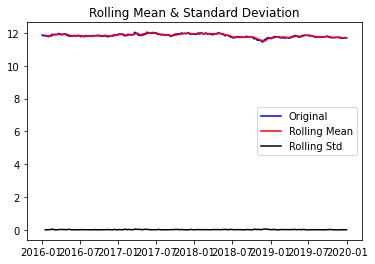

In [23]:
# 정성적 안정성 분석

plot_rolling_statistics(other1_ts_log, window=12)

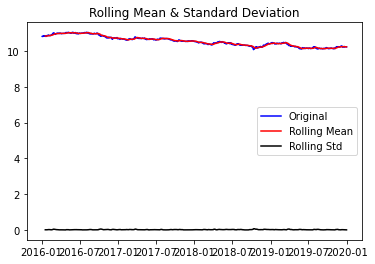

In [24]:
plot_rolling_statistics(other2_ts_log, window=12)

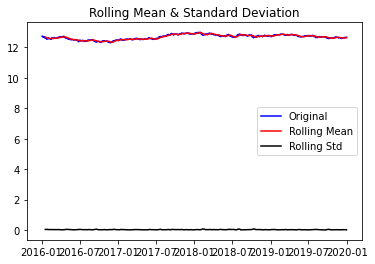

In [25]:
plot_rolling_statistics(other3_ts_log, window=12)

In [26]:
# 정량적 Augmented Dicky-Fuller Test
    
augmented_dickey_fuller_test(other1_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.445632
p-value                          0.129269
#Lags Used                       0.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64


In [27]:
augmented_dickey_fuller_test(other2_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.804220
p-value                          0.817879
#Lags Used                       0.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64


In [28]:
augmented_dickey_fuller_test(other3_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.950857
p-value                          0.308527
#Lags Used                       0.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64


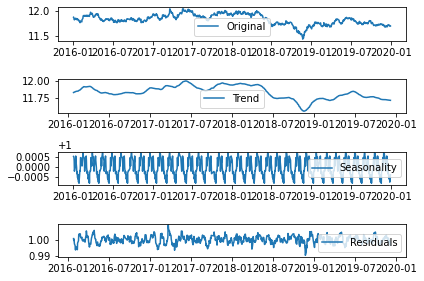

In [29]:
#시계열 분해 (Time Series Decomposition)

other1_decom = seasonal_decompose(other1_ts_log, model='multiplicative', period = 30) 

other1_trend = other1_decom.trend
other1_seasonal = other1_decom.seasonal
other1_residual = other1_decom.resid

plt.subplot(411)
plt.plot(other1_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(other1_trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(other1_seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(other1_residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

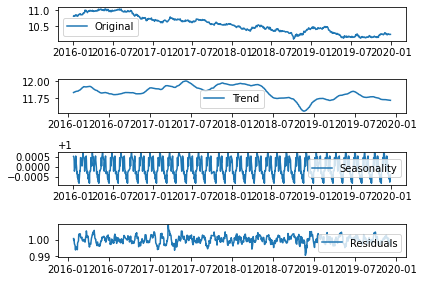

In [30]:
#시계열 분해 (Time Series Decomposition)

other2_decom = seasonal_decompose(other1_ts_log, model='multiplicative', period = 30) 

other2_trend = other2_decom.trend
other2_seasonal = other2_decom.seasonal
other2_residual = other2_decom.resid

plt.subplot(411)
plt.plot(other2_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(other2_trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(other2_seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(other2_residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

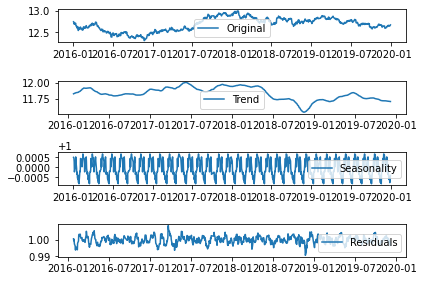

In [31]:
#시계열 분해 (Time Series Decomposition)

other3_decom = seasonal_decompose(other1_ts_log, model='multiplicative', period = 30) 

other3_trend = other3_decom.trend
other3_seasonal = other3_decom.seasonal
other3_residual = other3_decom.resid

plt.subplot(411)
plt.plot(other3_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(other3_trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(other3_seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(other3_residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [32]:
# Residual 안정성 확인
other1_residual.dropna(inplace=True)
augmented_dickey_fuller_test(other1_residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.114851e+01
p-value                        2.984072e-20
#Lags Used                     1.100000e+01
Number of Observations Used    9.370000e+02
Critical Value (1%)           -3.437348e+00
Critical Value (5%)           -2.864630e+00
Critical Value (10%)          -2.568415e+00
dtype: float64


In [33]:
other2_residual.dropna(inplace=True)
augmented_dickey_fuller_test(other2_residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.114851e+01
p-value                        2.984072e-20
#Lags Used                     1.100000e+01
Number of Observations Used    9.370000e+02
Critical Value (1%)           -3.437348e+00
Critical Value (5%)           -2.864630e+00
Critical Value (10%)          -2.568415e+00
dtype: float64


In [34]:
other3_residual.dropna(inplace=True)
augmented_dickey_fuller_test(other3_residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.114851e+01
p-value                        2.984072e-20
#Lags Used                     1.100000e+01
Number of Observations Used    9.370000e+02
Critical Value (1%)           -3.437348e+00
Critical Value (5%)           -2.864630e+00
Critical Value (10%)          -2.568415e+00
dtype: float64


## (4) 학습, 테스트 데이터셋 생성

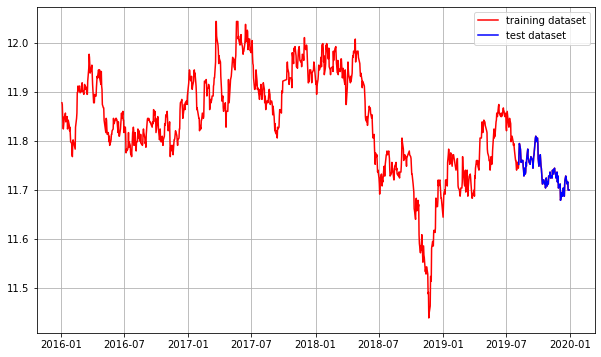

In [35]:
other1_train_data, other1_test_data = other1_ts_log[:int(len(other1_ts_log)*0.9)], other1_ts_log[int(len(other1_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(other1_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(other1_test_data, c='b', label='test dataset')
plt.legend()

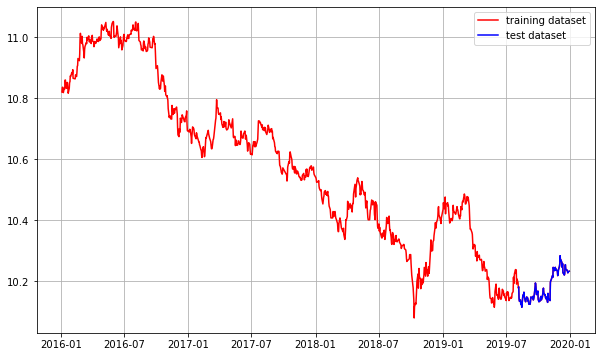

In [36]:
other2_train_data, other2_test_data = other2_ts_log[:int(len(other2_ts_log)*0.9)], other2_ts_log[int(len(other2_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(other2_ts_log, c='r', label='training dataset') 
plt.plot(other2_test_data, c='b', label='test dataset')
plt.legend()

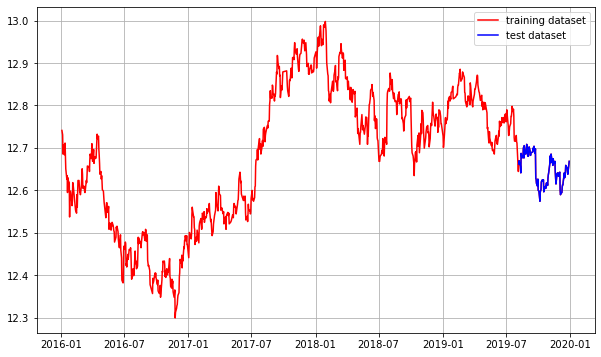

In [37]:
other3_train_data, other3_test_data = other3_ts_log[:int(len(other3_ts_log)*0.9)], other3_ts_log[int(len(other3_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(other3_ts_log, c='r', label='training dataset')  
plt.plot(other3_test_data, c='b', label='test dataset')
plt.legend()

## (5) ARIMA 모델 모수 찾기

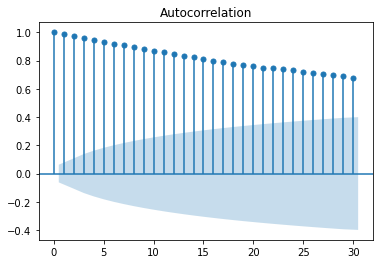

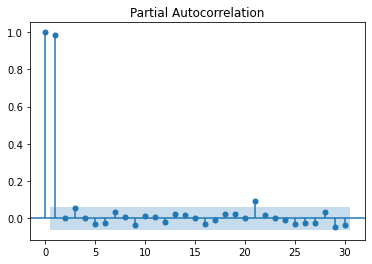

In [38]:
# ACF, PACF 그리기

plot_acf(other1_ts_log)   
plot_pacf(other1_ts_log)  
plt.show()

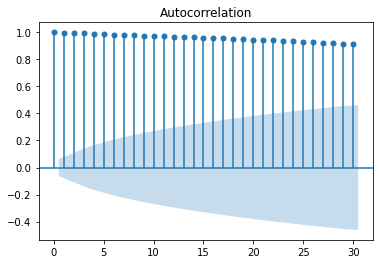

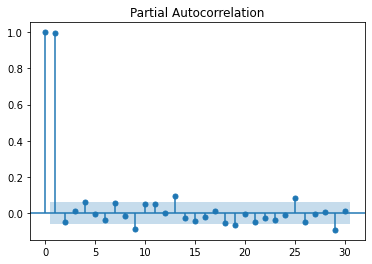

In [39]:
plot_acf(other2_ts_log)   
plot_pacf(other2_ts_log)  
plt.show()

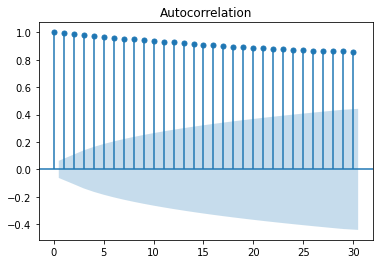

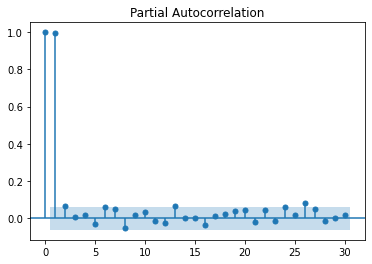

In [40]:
plot_acf(other3_ts_log)   
plot_pacf(other3_ts_log)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -31.491499
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


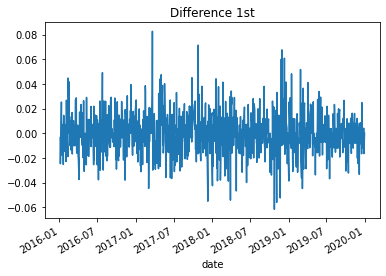

In [41]:
# 차분 안정성 확인

# 1차 차분 구하기
other1_diff_1 = other1_ts_log.diff(periods=1).iloc[1:]
other1_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(other1_diff_1)



Results of Dickey-Fuller Test:
Test Statistic                 -30.161664
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


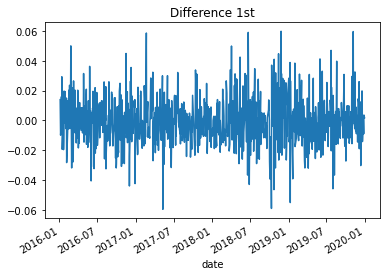

In [42]:
other2_diff_1 = other2_ts_log.diff(periods=1).iloc[1:]
other2_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(other2_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                 -33.161696
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


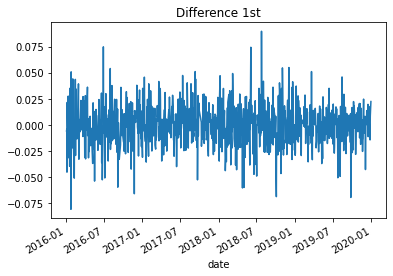

In [43]:
other3_diff_1 = other3_ts_log.diff(periods=1).iloc[1:]
other3_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(other3_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.131280e+01
p-value                        1.227156e-20
#Lags Used                     2.200000e+01
Number of Observations Used    9.540000e+02
Critical Value (1%)           -3.437223e+00
Critical Value (5%)           -2.864574e+00
Critical Value (10%)          -2.568386e+00
dtype: float64


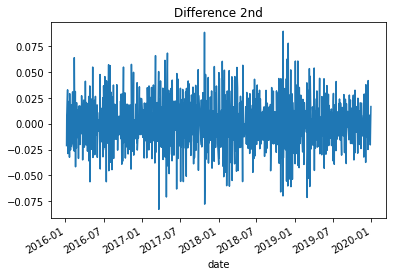

In [44]:
# 2차 차분 구하기
other1_diff_2 = other1_diff_1.diff(periods=1).iloc[1:]
other1_diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(other1_diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -1.217723e+01
p-value                        1.377337e-22
#Lags Used                     2.100000e+01
Number of Observations Used    9.550000e+02
Critical Value (1%)           -3.437216e+00
Critical Value (5%)           -2.864571e+00
Critical Value (10%)          -2.568384e+00
dtype: float64


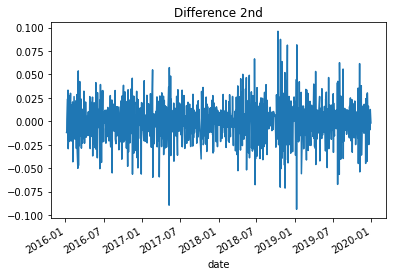

In [45]:
other2_diff_2 = other2_diff_1.diff(periods=1).iloc[1:]
other2_diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(other2_diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -1.159858e+01
p-value                        2.682994e-21
#Lags Used                     2.000000e+01
Number of Observations Used    9.560000e+02
Critical Value (1%)           -3.437209e+00
Critical Value (5%)           -2.864568e+00
Critical Value (10%)          -2.568382e+00
dtype: float64


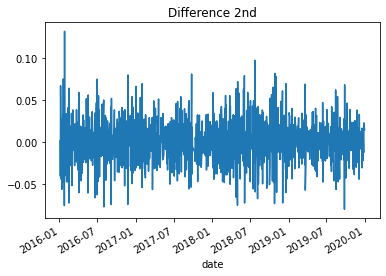

In [46]:
other3_diff_2 = other3_diff_1.diff(periods=1).iloc[1:]
other3_diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(other3_diff_2)

## (6) ARIMA 모델 훈련과 테스트

In [47]:
# ARIMA Model
other1_model = ARIMA(other1_train_data, order=(0, 2, 10))  
other1_fitted_m = other1_model.fit() 

print(other1_fitted_m.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. U

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  881
Model:                ARIMA(0, 2, 10)   Log Likelihood                2300.362
Date:                Thu, 17 Feb 2022   AIC                          -4578.723
Time:                        03:17:49   BIC                          -4526.157
Sample:                             0   HQIC                         -4558.620
                                - 881                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0022      0.037    -26.984      0.000      -1.075      -0.929
ma.L2         -0.0428      0.052     -0.830      0.406      -0.144       0.058
ma.L3          0.0393      0.047      0.830      0.4

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
# ARIMA Model
other2_model = ARIMA(other2_train_data, order=(2, 0, 20))  
other2_fitted_m = other2_model.fit() 

print(other2_fitted_m.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  881
Model:                ARIMA(2, 0, 20)   Log Likelihood                2402.628
Date:                Thu, 17 Feb 2022   AIC                          -4757.256
Time:                        03:17:51   BIC                          -4642.511
Sample:                             0   HQIC                         -4713.378
                                - 881                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5848      0.203     52.024      0.000      10.186      10.984
ar.L1          0.8631      2.817      0.306      0.759      -4.657       6.384
ar.L2          0.1344      2.811      0.048      0.9

In [49]:
# ARIMA Model
other3_model = ARIMA(other3_train_data, order=(2, 0, 20))  
other3_fitted_m = other3_model.fit() 

print(other3_fitted_m.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  881
Model:                ARIMA(2, 0, 20)   Log Likelihood                2217.537
Date:                Thu, 17 Feb 2022   AIC                          -4387.075
Time:                        03:17:57   BIC                          -4272.330
Sample:                             0   HQIC                         -4343.197
                                - 881                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6850      0.125    101.806      0.000      12.441      12.929
ar.L1          1.0836     57.110      0.019      0.985    -110.849     113.016
ar.L2         -0.0874     56.874     -0.002      0.9

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


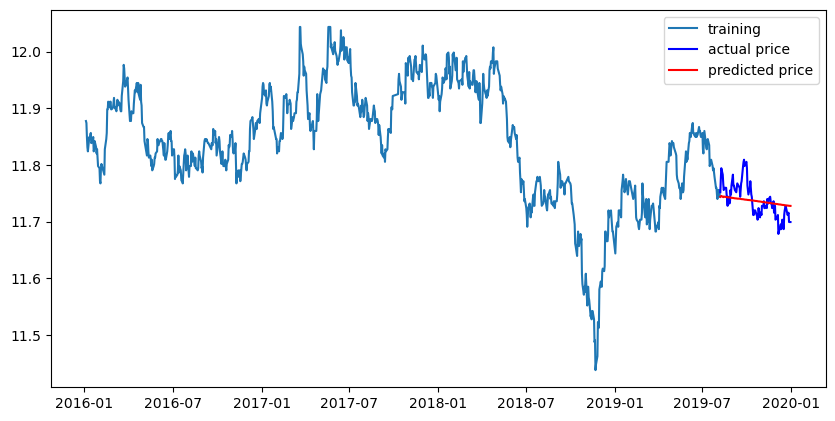

In [50]:
# Forecast 
other1_fc = other1_fitted_m.forecast(len(other1_test_data), alpha=0.05)  # 95% conf
other1_fc = np.array(other1_fc)
other1_fc_series = pd.Series(other1_fc, index=other1_test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(other1_train_data, label='training')
plt.plot(other1_test_data, c='b', label='actual price')
plt.plot(other1_fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


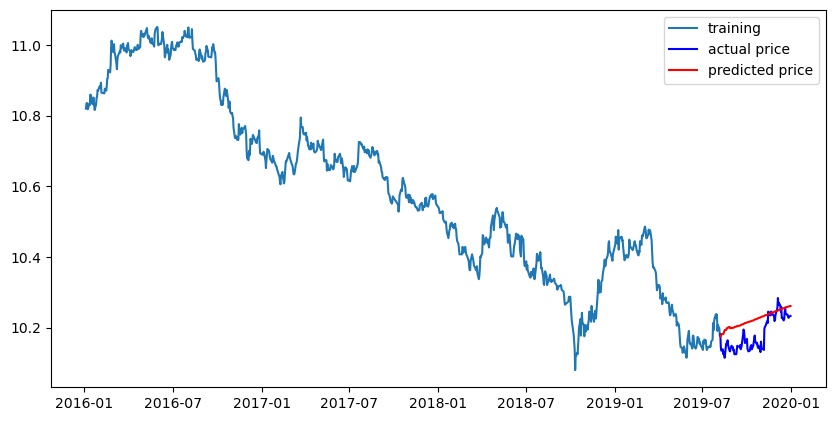

In [51]:
# Forecast 
other2_fc = other2_fitted_m.forecast(len(other2_test_data), alpha=0.05)  # 95% conf
other2_fc = np.array(other2_fc)
other2_fc_series = pd.Series(other2_fc, index=other2_test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(other2_train_data, label='training')
plt.plot(other2_test_data, c='b', label='actual price')
plt.plot(other2_fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


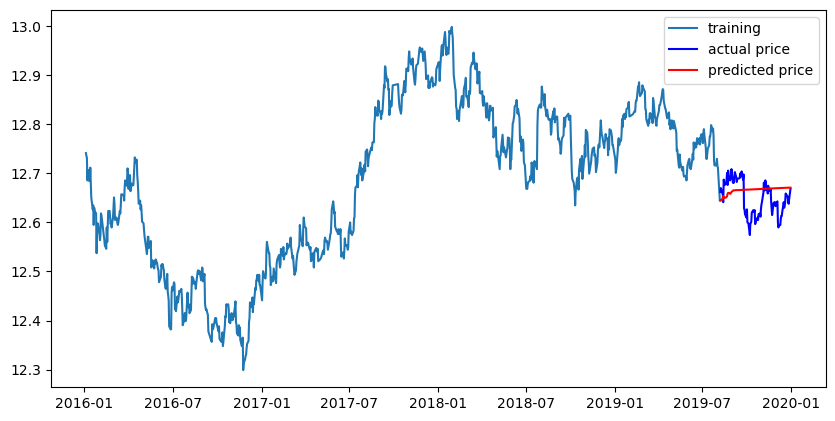

In [52]:
# Forecast 
other3_fc = other3_fitted_m.forecast(len(other3_test_data), alpha=0.05)  # 95% conf
other3_fc = np.array(other3_fc)
other3_fc_series = pd.Series(other3_fc, index=other3_test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(other3_train_data, label='training')
plt.plot(other3_test_data, c='b', label='actual price')
plt.plot(other3_fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [53]:
# 최종 결과 및 MAPE 측정
other1_mse = mean_squared_error(np.exp(other1_test_data), np.exp(other1_fc))
print('MSE: ', other1_mse)

other1_mae = mean_absolute_error(np.exp(other1_test_data), np.exp(other1_fc))
print('MAE: ', other1_mae)

other1_rmse = math.sqrt(mean_squared_error(np.exp(other1_test_data), np.exp(other1_fc)))
print('RMSE: ', other1_rmse)

other1_mape = np.mean(np.abs(np.exp(other1_fc) - np.exp(other1_test_data))/np.abs(np.exp(other1_test_data)))
print('MAPE: {:.2f}%'.format(other1_mape*100))

MSE:  11545123.228944652
MAE:  2658.2010657471697
RMSE:  3397.811535230383
MAPE: 2.11%


In [54]:
# 최종 결과 및 MAPE 측정
other2_mse = mean_squared_error(np.exp(other2_test_data), np.exp(other2_fc))
print('MSE: ', other2_mse)

other2_mae = mean_absolute_error(np.exp(other2_test_data), np.exp(other2_fc))
print('MAE: ', other2_mae)

other2_rmse = math.sqrt(mean_squared_error(np.exp(other2_test_data), np.exp(other2_fc)))
print('RMSE: ', other2_rmse)

other2_mape = np.mean(np.abs(np.exp(other2_fc) - np.exp(other2_test_data))/np.abs(np.exp(other2_test_data)))
print('MAPE: {:.2f}%'.format(other2_mape*100))

MSE:  1899376.4208197922
MAE:  1181.5857043977455
RMSE:  1378.1786607039714
MAPE: 4.58%


In [55]:
# 최종 결과 및 MAPE 측정
other3_mse = mean_squared_error(np.exp(other3_test_data), np.exp(other3_fc))
print('MSE: ', other3_mse)

other3_mae = mean_absolute_error(np.exp(other3_test_data), np.exp(other3_fc))
print('MAE: ', other3_mae)

other3_rmse = math.sqrt(mean_squared_error(np.exp(other3_test_data), np.exp(other3_fc)))
print('RMSE: ', other3_rmse)

other3_mape = np.mean(np.abs(np.exp(other3_fc) - np.exp(other3_test_data))/np.abs(np.exp(other3_test_data)))
print('MAPE: {:.2f}%'.format(other3_mape*100))

MSE:  157244333.56925568
MAE:  10865.416420489712
RMSE:  12539.710266559418
MAPE: 3.54%


# 회고
- 원본 데이터의 품질이 최고다. 코로나 이후 엄청난 스윙은 모델의 실패를 여실히 보여주었다.
- 그래서 예전에 쌓아뒀던 데이터(~2020.01)를 이용했다. 숫자를 많이 만지지 않고도 MAPE 5% 이하 값에 금방 들어왔다.
- order를 여러 번 만져가며 예측값이 다르게 나오는 것을 확인했다. p값을 높이자 우상향이던 예측이 아래로 향했는데.. 신뢰성이 떨어지는 장면. 모수 추정은.. GG. 
- q 값을 높여주었더니 꺾임이 생겨서 뭔가 그럴듯해 졌다. 100을 주니 엄청나게 오래 연산을 하는데.. 자원 점유를 확인해보니 GPU는 쓰지 않는다는 흥미로운 결과를 확인하였다. 하지만 최종값은 큰 차이가 없어 10~20정도로 낮추었다.
- 다른 프로젝트를 위해 시간 투자는 여기까지.
